# Lecture 20: Transformers

MTU Spring 2024

Instructor: Abel Reyes

### Announcements

- HW7 grades are in progress
- Quiz 3 grades in progress (yet)
- HW8 already on canvas (due next Friday)
- Final course project guidelines on canvas.
- Quiz 4 this Friday (DNN and CNN)!

### Learning outcomes
- Understand what is Transformers and its main componets.
- Explore the use of Transformers in NLP and CV
- Go through some examples

## Neural Machine Translation with Transformers (Tensorflow-GPU)
In the universe of natural language processing (NLP), text classification is a relatively simple task. At the opposite end of the difficulty spectrum lies neural machine translation (NMT), which uses deep learning to translate text from one language to another – for example, turning “Hello world” into “Salut le monde.” NMT has proven superior to the rules-based machine translation (RBMT) and statistical machine translation (SMT) systems that predated the explosion of deep learning and today is the basis for virtually all state-of-the-art text-translation services. Let's use Keras and TensorFlow to build a transformer-based NMT model that translates English to French. This exercise requires KerasNLP, so be sure to install it if it isn't installed already.

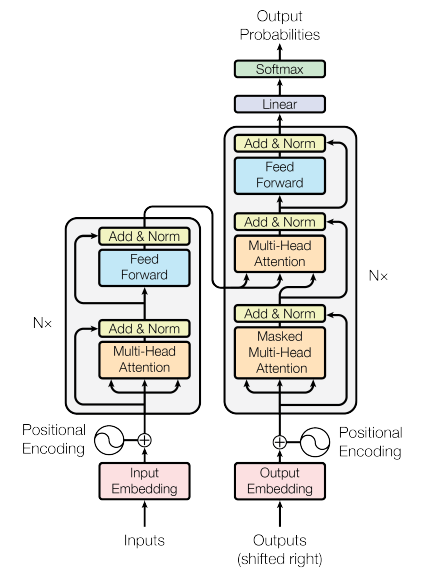
https://arxiv.org/abs/1706.03762

### Load and prepare the data
en-fr.txt is a subset of a larger file containing more than 190,000 phrases and their corresponding translations compiled as part of the Tatoeba project. The file is tab-delimited. Each line contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. We don’t need the attributions, so load the dataset into a Pandas DataFrame, remove the attribution column, and shuffle and reindex the rows.

In [1]:
import torch

print(torch.cuda.is_available())

if torch.cuda.is_available():
    print("Cuda is Availabe")
else:
    print("Cuda Can't be found")

True
Cuda is Availabe


In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import keras 
print(keras.__version__)

2.10.0


In [2]:
import pandas as pd

df = pd.read_csv('data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


Clean the text by removing punctuation symbols and numbers, converting characters to lowercase, and replacing Unicode characters with their ASCII equivalents. For the French samples, insert [start] and [end] tokens at the beginning and end of each phrase

In [3]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


The next step is to scan the phrases and determine the maximum length of the English phrases and then of the French phrases. These lengths will determine the lengths of the sequences input to and output from the model:



In [4]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


Now fit one Tokenizer to the English phrases and another Tokenizer to their French equivalents, and generate padded sequences for all the phrases:

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

Compute the vocabulary sizes from the Tokenizer instances:



In [8]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12197


Finally, create the features and the labels the model will be trained with. The features are the padded English sequences and the padded French sequences minus the [end] tokens. The labels are the padded French sequences minus the [start] tokens. Package the features in a dictionary so they can be input to a model that accepts multiple inputs.



In [9]:
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

### Build and train a model


Now use Keras's functional API to define a model that includes a transformer encoder and a transformer decoder. The model accepts two inputs: padded English sequences for the encoder, and padded French sequences for the decoder. The output from the decoder is fed to a softmax output layer for classification.



In [9]:
#!pip install keras_nlp

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

Using TensorFlow backend


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

num_heads = 2
embed_dim = 256

In [13]:
encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

In [14]:
decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

In [15]:
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 encoder_input (InputLayer)            [(None, None)]             0             []                                      
                                                                                                                        
 token_and_position_embedding (TokenAn  (None, None, 256)         1548544       ['encoder_input[0][0]']                 
 dPositionEmbedding)                                                                                                    
                                                                                                                        
 decoder_input (InputLayer)            [(None, None)]             0             []                                      
               

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, batch_size=32, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 25s 17ms/step - loss: 1.2029 - accuracy: 0.5237 - val_loss: 0.8772 - val_accuracy: 0.6157
Epoch 2/50
1250/1250 [==============================] - 21s 16ms/step - loss: 0.7524 - accuracy: 0.6517 - val_loss: 0.6849 - val_accuracy: 0.6837
Epoch 3/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5608 - accuracy: 0.7096 - val_loss: 0.6075 - val_accuracy: 0.7080
Epoch 4/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4515 - accuracy: 0.7444 - val_loss: 0.5790 - val_accuracy: 0.7223
Epoch 5/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3812 - accuracy: 0.7679 - val_loss: 0.5669 - val_accuracy: 0.7340
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3340 - accuracy: 0.7859 - val_loss: 0.5579 - val_accuracy: 0.7347
Epoch 7/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3014 - accuracy: 0.7991 - val_loss: 0.5576 -

[]

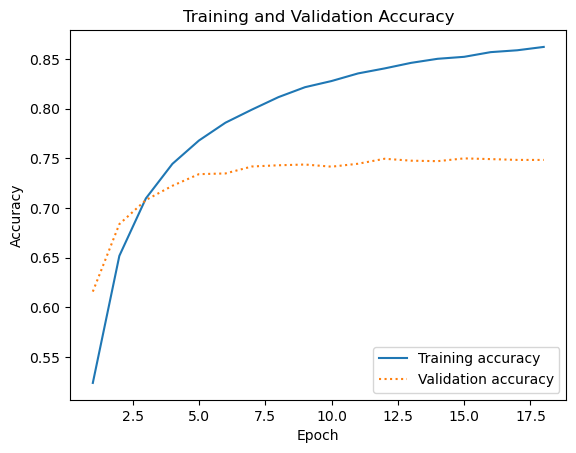

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [19]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]

        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break

    return decoded_text[8:-6] # Remove [start] and [end] tokens



In [20]:
fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)
    print(f'{text} => {translated}')

its fall now => cest maintenant que je suis prete
im losing => je perds
it was quite funny => ce fut plutot amusant
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que je pense faire ca
tom looks different => tom a lair different
its worth a try => ca vaut le coup dessayer
fortune smiled on him => la chance lui a souri
lets hit the road => on ma frappe
i love winning => jadore gagner


In [21]:
translate_text('Hello world', model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)


'salut ca'

## Sentiment Analysis with BERT (PyTorch GPU)
State-of-the-art sentiment analysis can be accomplished by fine-tuning pretrained BERT models with sentiment-analysis datasets. Fine-tuning is accomplished by further training a pretrained model for a limited number of epochs and with a reduced learning rate. Let’s fine-tune BERT and see if we can create a sentiment-analysis model that’s more accurate than a bag-of-words model. If your computer isn’t equipped with a GPU, consider running this example in Google Colab. Even on GPU, it can take an hour or so to run – depending on the type of GPU, of course.



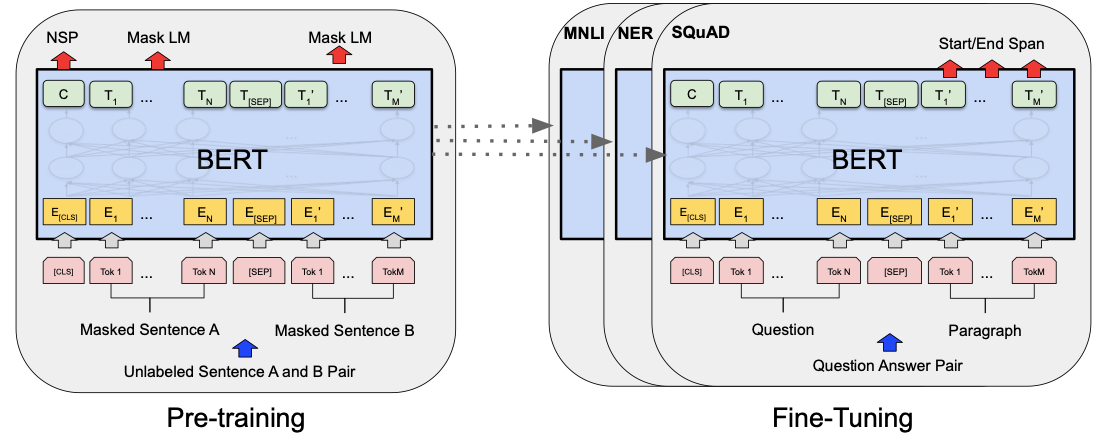

https://arxiv.org/abs/1810.04805

In [7]:
!pip install transformers
!pip install datasets

  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
  Using cached regex-2023.12.25-cp310-cp310-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.15.2-cp310-none-win_amd64.whl.metadata (6.8 kB)
  Using cached safetensors-0.4.2-cp310-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)
Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
Using cached regex-2023.12.25-cp310-cp310-win_amd64.whl (269 kB)
Using cached safetensors-0.4.2-cp310-none-win_amd64.whl (269 kB)
Using cached tokenizers-0.15.2-cp310-none-win_amd64.whl (2.2 MB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached pya

In [8]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

C:\Users\sanjay\anaconda3\envs\EET_4501_AML_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Ensure CUDA is available if you're using a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Next, load the IMDB dataset from the datasets package.:



In [4]:
# Load the dataset
dataset = load_dataset("imdb")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)


Create a tokenizer that tokenizes input text using the WordPiece format that BERT expects:


In [5]:
# Apply the tokenization function
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text to avoid any processing errors
tokenized_datasets.set_format("torch")  # Set the format to PyTorch tensors


Now that the reviews are tokenized, they need t be converted from Hugging Face datasets into PyTorch datasets with Hugging Face’s Dataset.to_tf_dataset method. The collating function passed to that method dynamically pads the sequences so they’re all the same length. You can also ask the tokenizer to do the padding, but padding performed that way is static and requires more memory:

In [6]:
# Use a data collator that dynamically pads the inputs and labels
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Convert to PyTorch DataLoader
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32, #8
    collate_fn=data_collator
)
validation_dataloader = DataLoader(
    tokenized_datasets["test"],
    batch_size=32, #8
    collate_fn=data_collator
)

In [7]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Now you’re ready to fine-tune. Call fit on the model as usual, but set the Adam optimizer’s learning rate (the nominal amount that weights and biases are adjusted during backpropagation passes) to 0.00002, which is a fraction of the default learning rate of 0.001:

In [8]:
# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_dataloader) * 3  # For 3 epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


C:\Users\sanjay\anaconda3\envs\EET4501_AML\lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
# Training loop
model.train()
for epoch in range(3):  # Let's do 3 epochs
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the appropriate device
        outputs = model(**batch)
        loss = outputs.loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.6869292259216309
Epoch 0, Loss: 0.6943198442459106
Epoch 0, Loss: 0.7092700600624084
Epoch 0, Loss: 0.6867876648902893
Epoch 0, Loss: 0.6885244250297546
Epoch 0, Loss: 0.7028874158859253
Epoch 0, Loss: 0.674385666847229
Epoch 0, Loss: 0.6766967177391052
Epoch 0, Loss: 0.6520093679428101
Epoch 0, Loss: 0.6652867197990417
Epoch 0, Loss: 0.6520600914955139
Epoch 0, Loss: 0.6410843133926392
Epoch 0, Loss: 0.5918859243392944
Epoch 0, Loss: 0.6876632571220398
Epoch 0, Loss: 0.5263795852661133
Epoch 0, Loss: 0.5477524995803833
Epoch 0, Loss: 0.7000854015350342
Epoch 0, Loss: 0.5199859142303467
Epoch 0, Loss: 0.4373945891857147
Epoch 0, Loss: 0.7033266425132751
Epoch 0, Loss: 0.5246773362159729
Epoch 0, Loss: 0.5480608344078064
Epoch 0, Loss: 0.4426305592060089
Epoch 0, Loss: 0.4503421485424042
Epoch 0, Loss: 0.37432727217674255
Epoch 0, Loss: 0.5349029898643494
Epoch 0, Loss: 0.3772243857383728
Epoch 0, Loss: 0.3668774664402008
Epoch 0, Loss: 0.3174388110637665
Epoch 0, Loss:

In [10]:
# Model evaluation (for demonstration purposes)
model.eval()
total_eval_accuracy = 0
for batch in validation_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    total_eval_accuracy += torch.sum(predictions == batch["labels"]).item()

avg_val_accuracy = total_eval_accuracy / len(tokenized_datasets["test"])
print(f"Validation Accuracy: {avg_val_accuracy}")

Validation Accuracy: 0.91244


In [11]:
def analyze_text(text, tokenizer, model, device):
    # Tokenize the input text
    tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Move tokenized text to the same device as the model
    tokenized_text = {k: v.to(device) for k, v in tokenized_text.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**tokenized_text)

    # Extract logits
    logits = outputs.logits

    # Compute softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Assuming we're interested in the probability of the second class (index 1)
    probability = probabilities[:, 1].item()

    return probability



In [12]:
# Example usage:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)  # Ensure the model is on the right device


In [13]:
print(analyze_text('Great food and excellent service!', tokenizer, model, device))

0.9984042048454285


In [14]:
analyze_text('The long lines and poor customer service really turned me off.', tokenizer, model, device)


0.003780587576329708

### TransUnet for medical image segmentation (Tensorflow GPU)

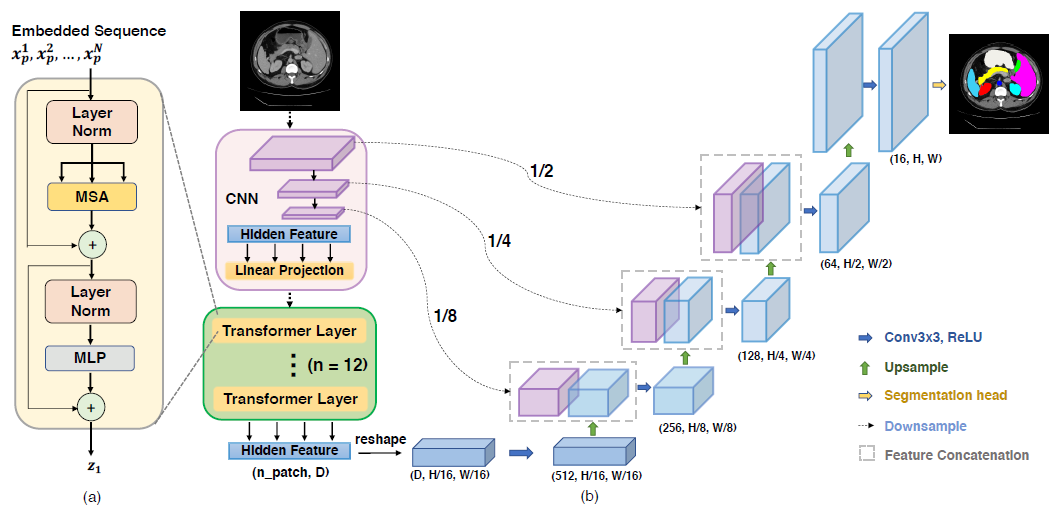

https://arxiv.org/abs/2102.04306

In [1]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import os
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


In [2]:
root="data/PH2/PH2Dataset/PH2 Dataset images"
size=128


In [3]:
def reading_images(root_path, files, type_im):
    images=[]
    for file in files:
        with h5py.File(root_path + file, 'r') as img_file:
            img_for_plot = img_file[type_im][()]
            images.append(img_for_plot)
    return images

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [4]:
imgs_path_list = sorted(filter(os.path.isfile,glob.glob(root+'/**/'+"**Dermoscopic_Image/"+'*bmp')))
masks_path_list = sorted(filter(os.path.isfile,glob.glob(root+'/**/'+"**lesion/"+'*bmp')))

masks=[]
imgs=[]
for idx in range(len(imgs_path_list)):
    img=np.array(Image.open(imgs_path_list[idx]).resize((size,size)), dtype=np.float32)/255
    mask=np.array(Image.open(masks_path_list[idx]).resize((size,size)), dtype=np.float32)
    #print(img.shape)
    imgs.append(img)
    masks.append(mask)
masks_arr=np.array(masks)
imgs_arr=np.array(imgs)
imgs_arr.shape

(200, 128, 128, 3)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(imgs_arr, masks_arr, test_size = 0.25, random_state = 101)

In [6]:
def display_images_and_masks(X_train, y_train):
    """
    Display 5 random images from X_train with their corresponding segmentation masks from y_train.
    
    Parameters:
    - X_train: numpy array of images.
    - y_train: numpy array of segmentation masks.
    """
    # Ensure there are at least 5 images
    assert len(X_train) >= 5, "X_train must contain at least 5 images."
    assert len(y_train) >= 5, "y_train must contain at least 5 masks."
    
    # Randomly select 5 unique indices
    indices = np.random.choice(len(X_train), 5, replace=False)
    
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    
    for i, index in enumerate(indices):
        ax = axes[i, 0]
        ax.imshow(X_train[index], cmap='gray')
        ax.set_title(f"Image {index}")
        ax.axis('off')
        
        ax = axes[i, 1]
        ax.imshow(y_train[index], cmap='gray')
        ax.set_title(f"Mask {index}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

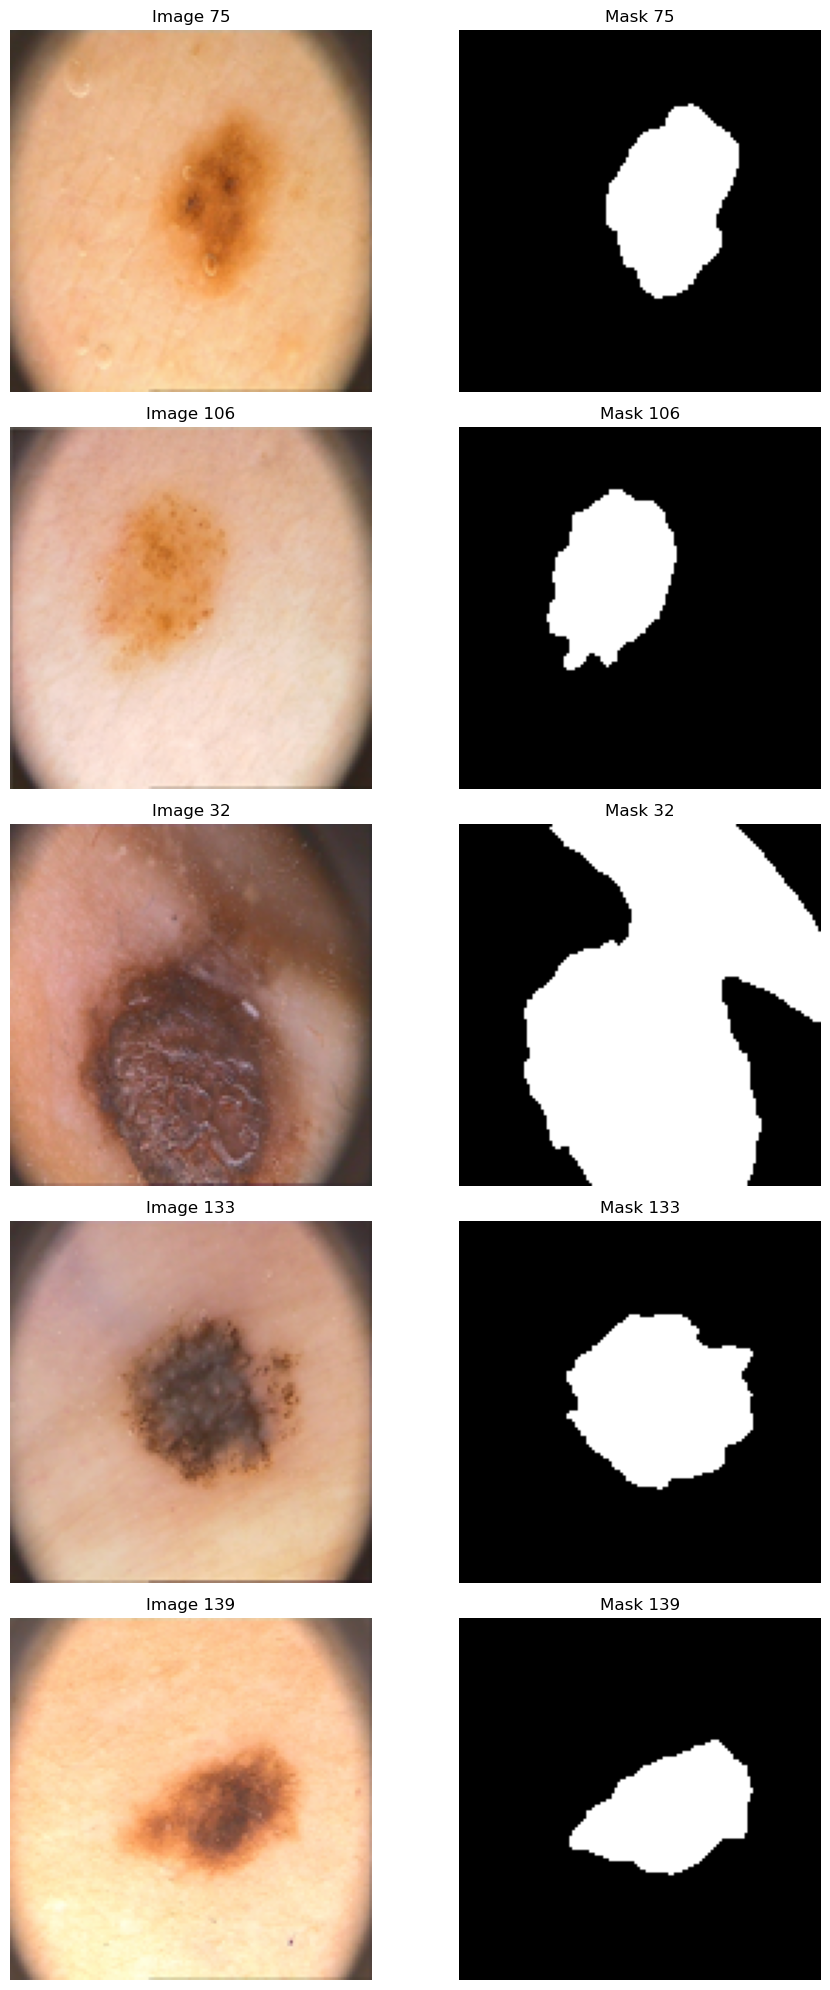

In [7]:
display_images_and_masks(X_train, y_train)

In [8]:
from keras_unet_collection import models
import pandas as pd

In [9]:
model = models.transunet_2d((size, size, 3), filter_num=[64, 128, 256, 512], n_labels=1, stack_num_down=2, stack_num_up=2,
                                embed_dim=256, num_mlp=1024, num_heads=4, num_transformer=4,
                                activation='ReLU', mlp_activation='GELU', output_activation='Sigmoid', 
                                batch_norm=True, pool=True, unpool='bilinear', name='transunet')

In [10]:
model.summary()

Model: "transunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 transunet_down0_0 (Conv2D)     (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 transunet_down0_0_bn (BatchNor  (None, 128, 128, 64  256        ['transunet_down0_0[0][0]']      
 malization)                    )                                                   

In [11]:
model.compile(optimizer= Adam(learning_rate = 0.001), 
              metrics=['accuracy'], 
              loss=  jaccard_distance
             )

In [12]:
# Define your model checkpoint
filepath=f'{model.name}_best.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath,  # Specify the path where you want to save the model
    save_weights_only=False,       # If True, only the model's weights will be saved (`.h5`), otherwise the full model is saved
    monitor='val_loss',            # Monitor the validation loss
    mode='min',                    # The checkpointing strategy, 'min' means the model is saved when the quantity monitored has decreased
    save_best_only=True,           # Only the best model is saved according to the quantity monitored
    verbose=1                      # Verbosity mode, 1 means you get messages about model updates
)

In [13]:
filepath

'transunet_model_best.hdf5'

In [14]:
model_history=model.fit(X_train, y_train,
                       batch_size=8,
                       epochs=50,
                        verbose=1,
                       validation_data=(X_test, y_test),
                        shuffle=True,
                        callbacks=[model_checkpoint_callback]
                       )

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.8456
Epoch 1: val_loss improved from inf to 0.38545, saving model to transunet_model_best.hdf5
19/19 [==============================] - 14s 279ms/step - loss: 0.0905 - accuracy: 0.8456 - val_loss: 0.3854 - val_accuracy: 0.3134
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.8733
Epoch 2: val_loss improved from 0.38545 to 0.35915, saving model to transunet_model_best.hdf5
19/19 [==============================] - 3s 156ms/step - loss: 0.0736 - accuracy: 0.8733 - val_loss: 0.3591 - val_accuracy: 0.3650
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.8830
Epoch 3: val_loss improved from 0.35915 to 0.22846, saving model to transunet_model_best.hdf5
19/19 [==============================] - 3s 156ms/step - loss: 0.0717 - accuracy: 0.8830 - val_loss: 0.2285 - val_accuracy: 0.6866
Epoch 4/50
19/19 [============================

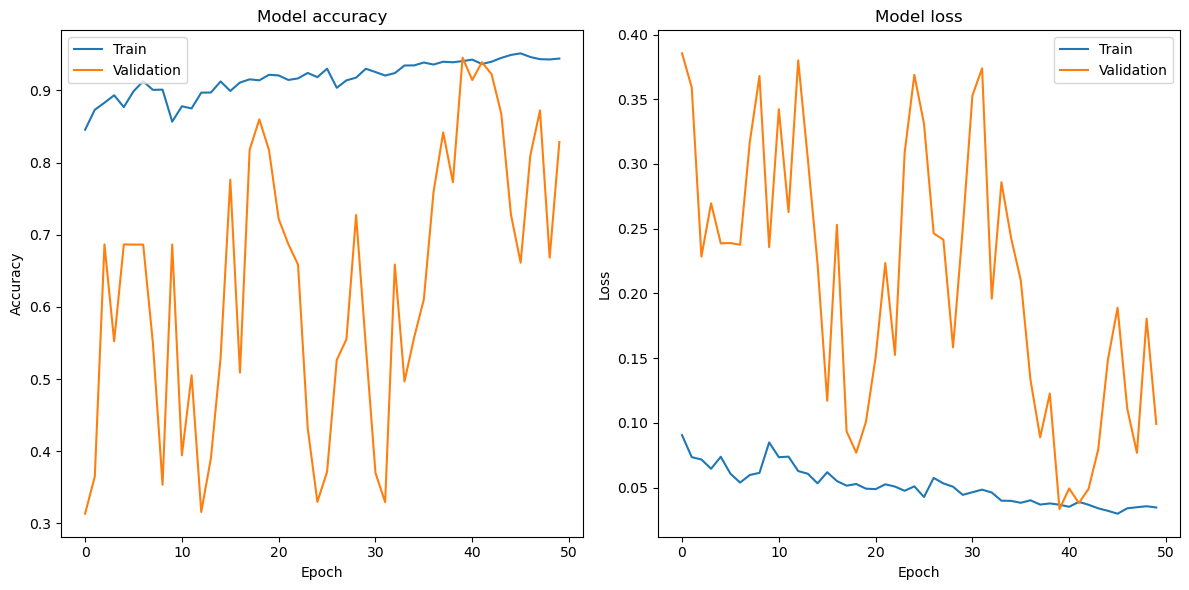

In [15]:
#%%
# Save the training history to a CSV file
history_df = pd.DataFrame(model_history.history)
history_df.to_csv(f"training_history.csv", index=False)
#%%
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Train')
plt.plot(model_history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Train')
plt.plot(model_history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()

In [17]:
model.load_weights(filepath)

In [18]:
predictions=model.predict(X_test)>0.5

2/2 [==============================] - 2s 263ms/step


In [19]:
def display_images_masks_predictions(X_train, y_train, predictions):
    """
    Display 5 random images from X_train with their corresponding segmentation masks from y_train
    and predicted masks from predictions.
    
    Parameters:
    - X_train: numpy array of images.
    - y_train: numpy array of true segmentation masks.
    - predictions: numpy array of predicted segmentation masks.
    """
    # Ensure there are at least 5 images and consistency in dataset size
    assert len(X_train) >= 5, "X_train must contain at least 5 images."
    assert len(y_train) >= 5, "y_train must contain at least 5 masks."
    assert len(predictions) >= 5, "predictions must contain at least 5 masks."
    assert len(X_train) == len(y_train) == len(predictions), "X_train, y_train, and predictions must have the same length."
    
    # Randomly select 5 unique indices
    indices = np.random.choice(len(X_train), 5, replace=False)
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # Adjusted for 3 columns
    
    for i, index in enumerate(indices):
        # Display the original image
        ax = axes[i, 0]
        ax.imshow(X_train[index], cmap='gray')
        ax.set_title(f"Image {index}")
        ax.axis('off')
        
        # Display the true mask
        ax = axes[i, 1]
        ax.imshow(y_train[index], cmap='gray')
        ax.set_title(f"True Mask {index}")
        ax.axis('off')
        
        # Display the predicted mask
        ax = axes[i, 2]
        ax.imshow(predictions[index], cmap='gray')
        ax.set_title(f"Predicted Mask {index}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

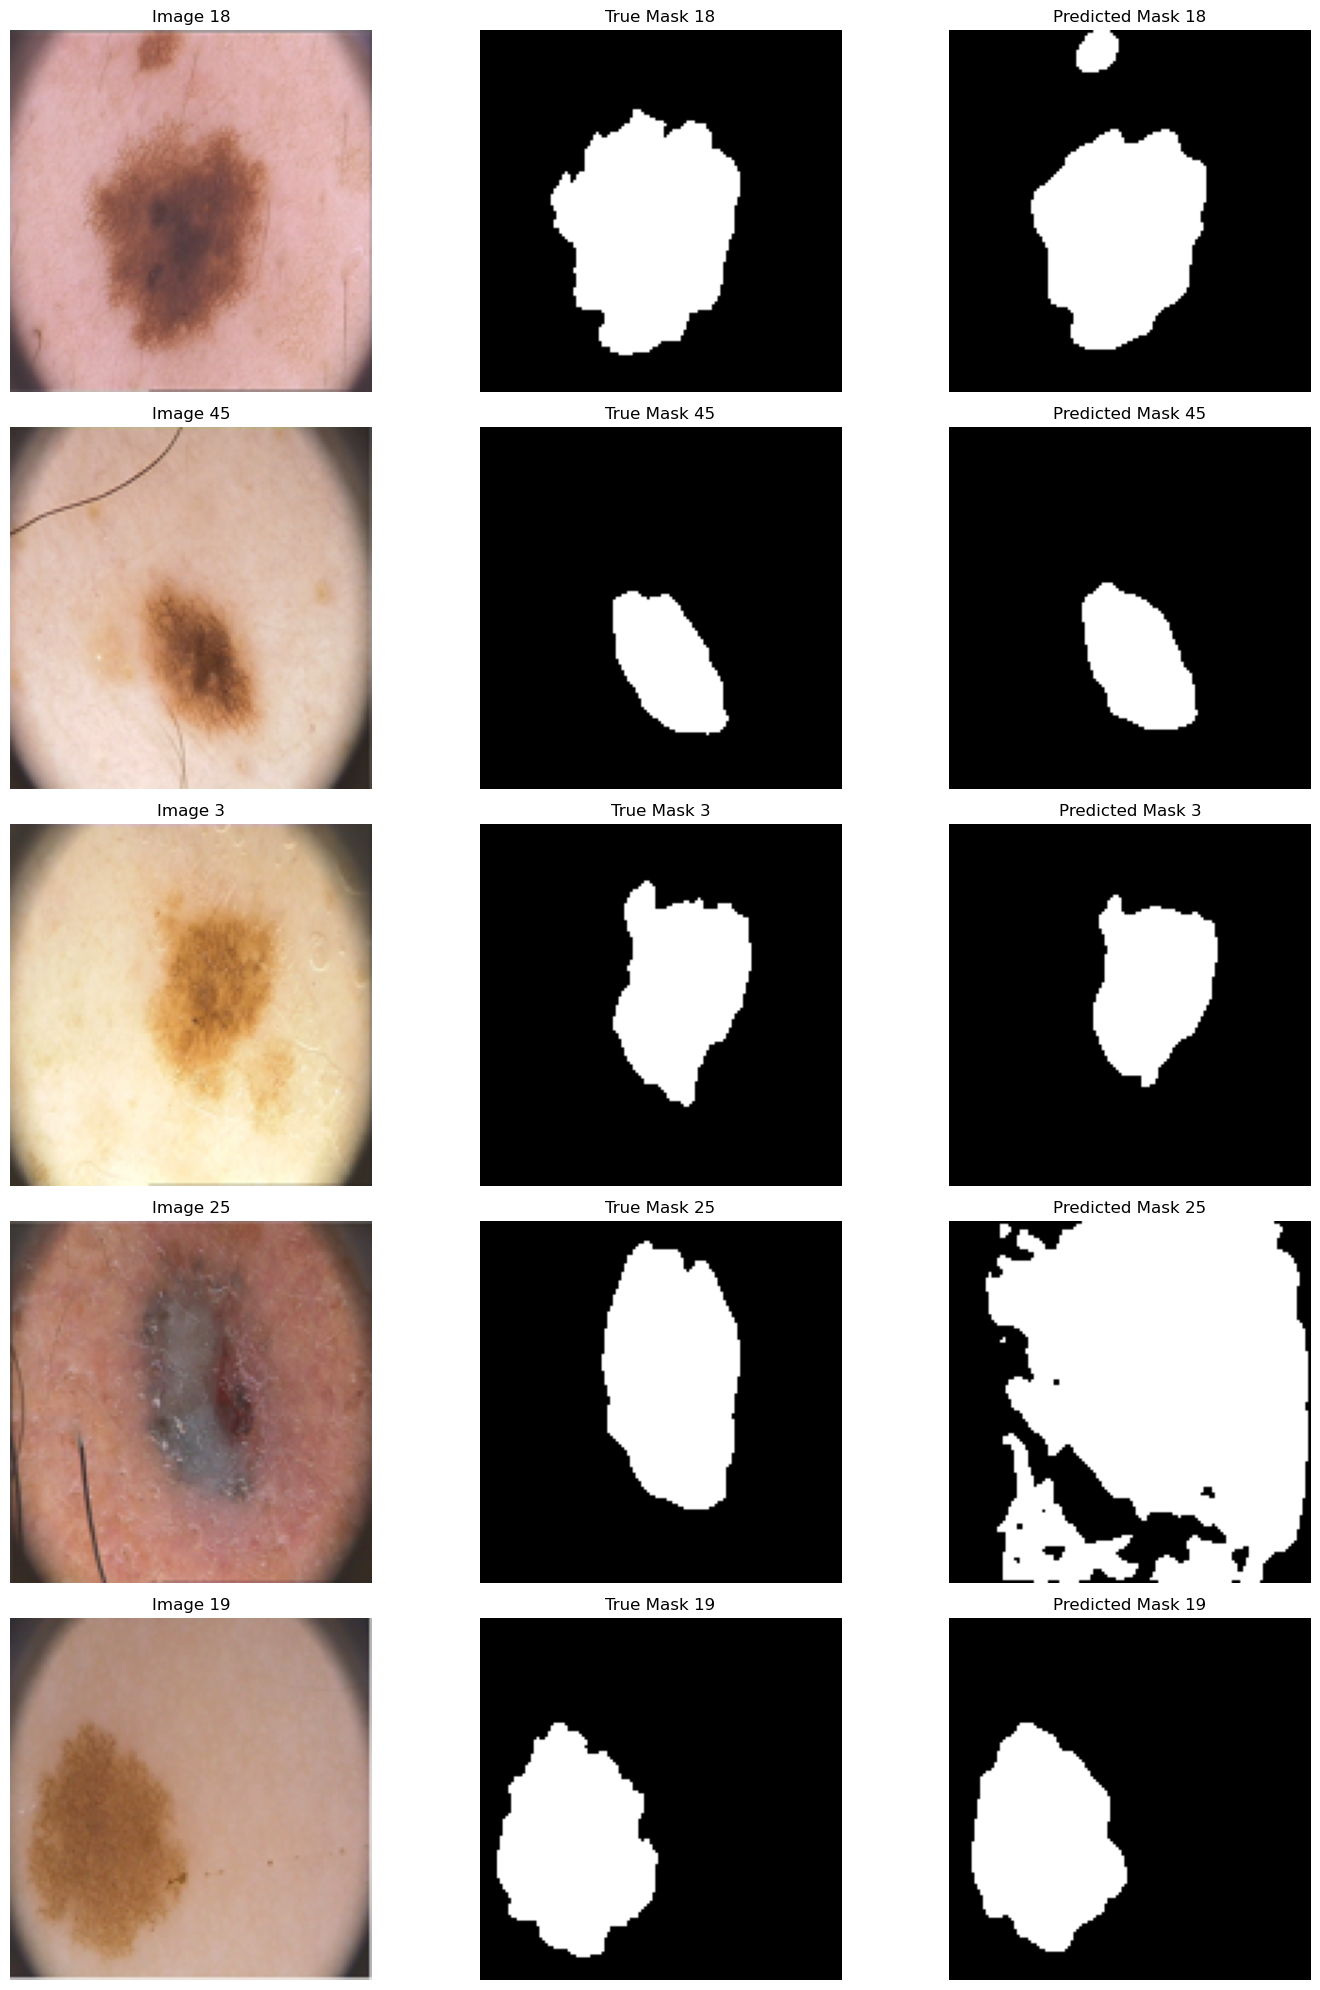

In [20]:
display_images_masks_predictions(X_test, y_test, predictions)

In [21]:
predictions.shape, y_test.shape

((50, 128, 128, 1), (50, 128, 128))

In [22]:
def mean_iou(y_test, predictions):
    """
    Compute the mean Intersection over Union (IoU) between two arrays of segmentation masks.
    
    Parameters:
    - y_test: numpy array of true segmentation masks.
    - predictions: numpy array of predicted segmentation masks.
    
    Returns:
    - mean_iou: The mean IoU score across all samples.
    """
    # Ensure predictions and ground truth have the same shape
    assert y_test.shape == predictions.shape, "Shape mismatch between ground truth and predictions"
    
    # Initialize list to store IoU scores
    iou_scores = []
    
    for true_mask, pred_mask in zip(y_test, predictions):
        # Intersection and union
        intersection = np.logical_and(true_mask, pred_mask)
        union = np.logical_or(true_mask, pred_mask)
        
        # Avoid division by zero
        iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
        iou_scores.append(iou_score)
    
    # Calculate mean IoU
    mean_iou = np.mean(iou_scores)
    return mean_iou

In [23]:
print(f'The mean Intersection over Union is: {mean_iou(np.expand_dims(y_test, axis=-1), predictions)}')

The mean Intersection over Union is: 0.8539100719813447
